## STEP 0: Load Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f

## STEP 1: Define RMSNORM Class

In [2]:
class RMSNorm(nn.Module):
    """Root-Mean-Square Layer Norm"""
    def __init__(self, d_model,eps: float=1e-8):
        super().__init__()
        self.eps=eps

    def forward(self,x):
        rms=torch.sqrt(torch.mean(x**2, dim=-1, keepdim=True) + self.eps)
        return x/rms

## STEP 2: Define The Multi Token Prediction(MTP) Class

![Screenshot 2025-05-31 124734.jpg](<attachment:Screenshot 2025-05-31 124734.jpg>)

## STEP 1 and 2
![](<attachment:step 1.jpg>)

## STEP 3
![step 2.jpg](<attachment:step 2.jpg>)

## STEP 4
![step 3.jpg](<attachment:step 3.jpg>)
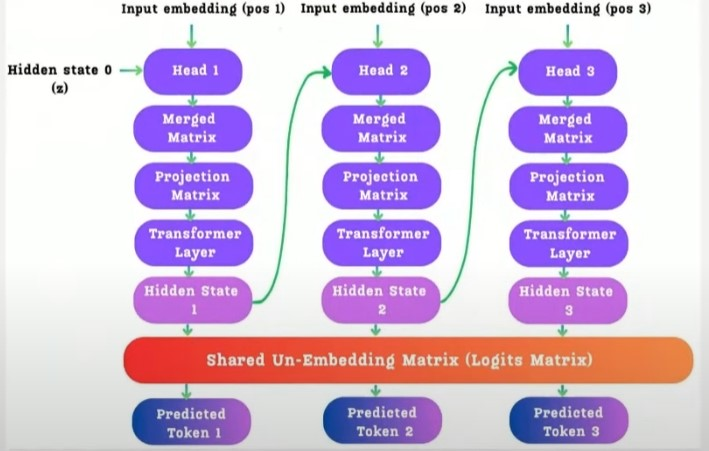
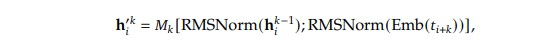
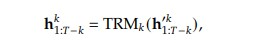
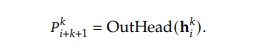

In [10]:
class MTP(nn.Module):
    def __init__(self, d_model: int, vocab_size: int, num_heads: int = 3, nhead: int = 2):
        """
        Multi-step Transformer Prediction module.

        Args:
            d_model (int): Hidden size
            vocab_size (int): Vocabulary size
            num_heads (int): Number of sequential MTP steps (D)
            nhead (int): Number of attention heads in each Transformer block
        """
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.nhead = nhead
        self.vocab_size = vocab_size

        # Shared modules
        self.rmsnorm = RMSNorm(d_model)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.unembed = nn.Linear(d_model, vocab_size, bias=False)

        # Share weights between embedding and unembedding
        self.unembed.weight = self.embed.weight

        # Per-head projections and transformer blocks
        self.projections = nn.ModuleList(
            [nn.Linear(2 * d_model, d_model) for _ in range(num_heads)]
        )
        self.transformers = nn.ModuleList(
            [nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead) for _ in range(num_heads)]
        )

    def forward(self, token_ids: torch.LongTensor, init_hidden: torch.Tensor = None):
        """
        Args:
            token_ids (Tensor): Shape (B, T), token IDs
            init_hidden (Tensor or None): Optional initial hidden state (B, T, d_model)

        Returns:
            logits_out (Tensor): Shape (B, T-D, D, vocab_size)
        """
        B, T = token_ids.shape
        device = token_ids.device

        # Embedding lookup
        embeds = self.embed(token_ids)  # (B, T, d_model)

        # Determine initial hidden state
        h0_seq = embeds if init_hidden is None else init_hidden  # (B, T, d_model)

        outputs = []
        max_i = T - self.num_heads - 1  # Ensure i + D <= T - 1

        for i in range(0, max_i + 1):
            h_prev = h0_seq[:, i, :]  # (B, d_model)
            logits_k = []

            for k in range(self.num_heads):
                future_pos = i + (k + 1)
                tok_embed = embeds[:, future_pos, :]  # (B, d_model)

                # 1) RMS normalization
                h_norm = self.rmsnorm(h_prev)
                tok_norm = self.rmsnorm(tok_embed)

                # 2) Concatenate and project
                merged = torch.cat([h_norm, tok_norm], dim=-1)  # (B, 2*d_model)
                proj = self.projections[k](merged)  # (B, d_model)

                # 3) Transformer expects (T, B, d_model)
                x = proj.unsqueeze(0)  # (1, B, d_model)
                x = self.transformers[k](x, memory=x)  # dummy self-attn for now

                h_curr = x.squeeze(0)  # (B, d_model)

                # 4) Project to vocabulary
                logits = self.unembed(h_curr)  # (B, vocab_size)
                logits_k.append(logits)

                h_prev = h_curr  # for next step in chain

            # Stack over D steps
            logits_k = torch.stack(logits_k, dim=1)  # (B, D, vocab_size)
            outputs.append(logits_k)

        # Stack over sequence -> (T-D, B, D, V) → (B, T-D, D, V)
        outputs = torch.stack(outputs, dim=0).permute(1, 0, 2, 3).contiguous()
        return outputs

## STEP 3: Pass Input Token Through the Model And Generate Multiple Next Tokens

In [13]:
batch_size,seq_len,d_model,vocab_size=1,8,8,5000
model=MTP(d_model=d_model,vocab_size=vocab_size,num_heads=3)
tokens=torch.randint(0,vocab_size,(batch_size,seq_len))

print(tokens.shape)
## FORWARD PASS 
logits=model(tokens)

## LOGITS.SHAPE == (1,4-3,3,5000)->(batch_size,T-D,D,V)
print("Logits Shape",logits.shape)

## IF YOU WANT TO INSPECT THE ! STEP AHEAD PROJECTION AT POSITION 0
print("Head k=0 at i=0 Logits",logits[0,0,0]) ## A TENSOR  LENGTH VOCAB_SIZE

## OR TO GET ALL PREDICTION AT i=0 as TOKEN IDS:
pred_ids=torch.argmax(logits[0,0],dim=-1)
print("All predictions at i=0",pred_ids) ## A LENGTH 3 TENSOR


torch.Size([1, 8])
Logits Shape torch.Size([1, 5, 3, 5000])
Head k=0 at i=0 Logits tensor([-3.0174,  3.5966, -5.6804,  ...,  0.9662, -0.2374,  6.5602],
       grad_fn=<SelectBackward0>)
All predictions at i=0 tensor([3395,  747, 1411])


## STEP 4: Calculate Loss Between Target Tokens and Predicted Tokens

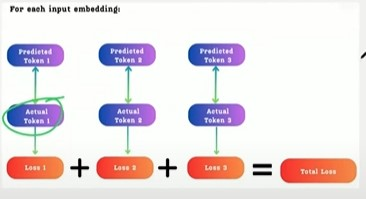

## MTP Training Objective.
![loss fucntion.jpg](<attachment:loss fucntion.jpg>)
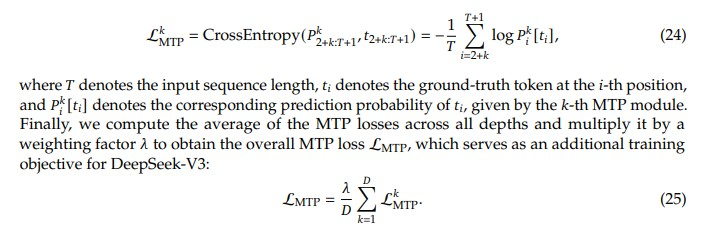

In [ ]:
batch_size,seq_len,vocab_size=1,8,5000

targets=torch.randint(0,vocab_size,(batch_size,seq_len))

print("targets.shape ->",targets.shape) ## torch.size([1,8])

logits=model(tokens)  ## Shape(1,5,3,5000)

B,L,D,V=logits.shape  ## (1,5,3,5000)

_,T=targets.shape     ## (1,8)

assert L==T-D         ## 5==8-3 passes

## DOUBLE LOOP LOSS
loss=0.0
for i in range(L):
    for k in range(D):
        logit_ik=logits[:,i,k,:]  ## (1,5000)
        target_ik=targets[:,i+(k+1)]  ## (1,)
        loss +=f.cross_entropy(logit_ik,target_ik)
loss=loss/(L*D)
print("MTP loss:",loss.item())

targets.shape -> torch.Size([1, 8])
MTP loss: 12.787327766418457
